In [895]:
#!pip install scikit-optimize

In [896]:
#!pip install scikit-learn

In [897]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.compose import ColumnTransformer

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_absolute_error

from sklearn.pipeline import Pipeline
from matplotlib.colors import ListedColormap
from sklearn.inspection import DecisionBoundaryDisplay
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

In [898]:
# Load the wine dataset
winedf = pd.read_csv('/content/winequality-white.csv', header=0, sep=';', dtype={
    'fixed acidity': 'float64',
    'volatile acidity': 'float64',
    'citric acid': 'float64',
    'residual sugar': 'float64',
    'chlorides': 'float64',
    'free sulfur dioxide': 'float64',
    'total sulfur dioxide': 'float64',
    'density': 'float64',
    'pH': 'float64',
    'sulphates': 'float64',
    'alcohol': 'float64',
    'quality': 'int32',
})
#print(winedf.head())

In [899]:
#winedf.describe().T

In [900]:
# Histogram to see distribution of features

#winedf.hist(bins=25, figsize=(10, 10))

In [901]:
# Correlation heatmap looking for redundant features

#plt.figure(figsize=(10, 10))
#sb.heatmap(winedf.corr(), linewidths=0.5, annot=True, cmap="coolwarm")
#plt.show()

In [902]:
winedf = winedf.drop('density', axis=1) # can comment out to try without dropping density


In [903]:
# Separate features from targets

X = winedf.drop('quality', axis=1)
Y = winedf['quality']

# Looking to see outliers
#for feat in X.columns.to_list():
#  sb.scatterplot(winedf, x=feat, y='quality')
#  plt.show()

# and there are noticeable outliers so should use a scaler that is robust to those
# quantile transformer documentation makes it seem appropriate, but will also use standard scaler just to see
# if there is a difference

In [904]:
# Split Data

x_train, X_test, y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)


In [905]:
# Scale and Train
Scaler = preprocessing.StandardScaler()

#scaleStep = ColumnTransformer(
    #transformers = [('trainScaler', Scaler, x_train.columns), ('testScaler', Scaler, X_test)]) # was gonna try to make this all happen in one step, but I'm not sure how to get it to split first and then scale like I was originally doing.

x_trainScaled = pd.DataFrame(Scaler.fit_transform(x_train), columns = x_train.columns)

 #note: not fit_transforming again, I'm using the same as from training
X_testScaled = pd.DataFrame(Scaler.transform(X_test), columns = X_test.columns)     # so not fitting scale on test data which should be unseen


#print('original shape: %s' % Counter(y_train))
#ros = RandomOverSampler(random_state=42)
#x_trainScaled, y_train = ros.fit_resample(x_trainScaled, y_train)  #tried random oversampling and it didn't improve things
#print('resampled shape: %s' % Counter(y_train))

classiModels = {'LRC': LogisticRegression(random_state=42, max_iter=1000),
                'DT': DecisionTreeClassifier(random_state=42),
                'RFC': RandomForestClassifier(random_state=42),
                'RBFSVM': SVC(kernel='rbf', random_state=42)}

baseOutput = {}


In [906]:
for model, classi in classiModels.items():
  pipeline = Pipeline(steps=[('classifier', classi)])
  scores = cross_val_score(pipeline, x_trainScaled, y_train, cv=5, scoring='accuracy')
  pipeline.fit(x_trainScaled, y_train)
  yPredict = pipeline.predict(X_testScaled)
  baseOutput[model] = {'Mean Train Accuracy': scores.mean(), 'Test Accuracy': accuracy_score(Y_test, yPredict)}

In [907]:
for model in baseOutput:
  print(f'{model} Train Accuracy: {baseOutput[model]["Mean Train Accuracy"]}')
  print(f'{model} Test Accuracy: {baseOutput[model]["Test Accuracy"]}')
  print("\n")


LRC Train Accuracy: 0.5400669846482654
LRC Test Accuracy: 0.5183673469387755


DT Train Accuracy: 0.5862606536867621
DT Test Accuracy: 0.6081632653061224


RFC Train Accuracy: 0.6618145150780619
RFC Test Accuracy: 0.7081632653061225


RBFSVM Train Accuracy: 0.5758089634321162
RBFSVM Test Accuracy: 0.5571428571428572




[Text(0, 0, 'LogisticRegression'),
 Text(1, 0, 'DecisionTree'),
 Text(2, 0, 'RandomForestClassifier'),
 Text(3, 0, 'RBF SVM')]

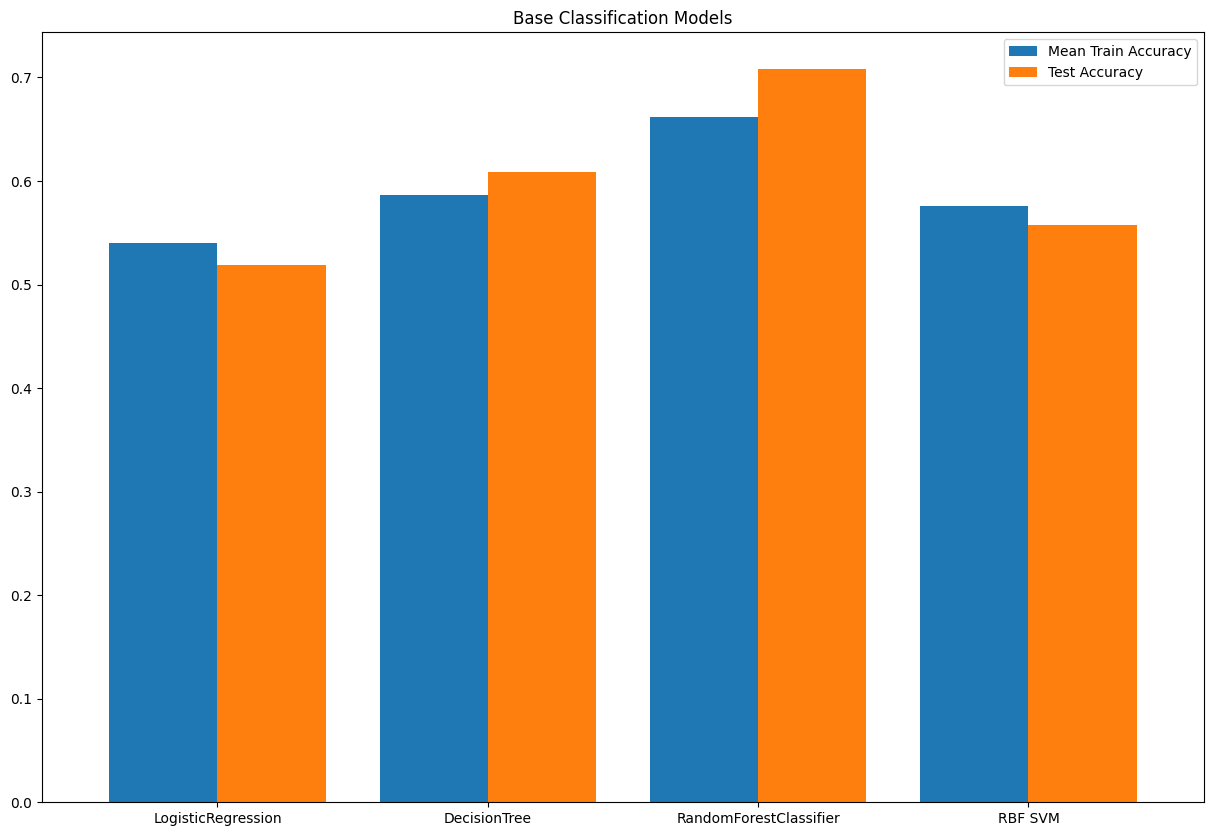

In [920]:
# Make a graph of scores
ClassiNames = list[baseOutput.keys()]
ClassiScores = [[baseOutput['LRC']['Mean Train Accuracy'], baseOutput['LRC']['Test Accuracy']],
                [baseOutput['DT']['Mean Train Accuracy'], baseOutput['DT']['Test Accuracy']],
                [baseOutput['RFC']['Mean Train Accuracy'], baseOutput['RFC']['Test Accuracy']],
                [baseOutput['RBFSVM']['Mean Train Accuracy'], baseOutput['RBFSVM']['Test Accuracy']]]

ClassiScoresDf = pd.DataFrame(ClassiScores, columns=['Mean Train Accuracy', 'Test Accuracy'])

PltClassiScoresDf = ClassiScoresDf.plot(kind='bar', title = "Base Classification Models", figsize=(15, 10), width=0.8)
PltClassiScoresDf.set_xticklabels(['LogisticRegression', 'DecisionTree', 'RandomForestClassifier', 'RBF SVM'], rotation = 0)

In [912]:
hyperSpace = {
    'LRC': {'classifier__C': Real(0.1, 10, prior='log-uniform')},
    'DT': {'classifier__max_depth': Integer(10, 100)},
    'RFC': {'classifier__n_estimators': Integer(100, 1000), 'classifier__max_depth': Integer(10, 100)},
    'RBFSVM': {'classifier__C': Real(0.1, 10, prior='log-uniform'), 'classifier__gamma': Categorical(['scale', 'auto'])}
    }

In [913]:
optiOutput ={}
for model, classi in classiModels.items(): # heh classy models
  pipeline = Pipeline(steps=[('classifier', classi)])
  bayeSearch = BayesSearchCV(pipeline, hyperSpace[model], n_iter=10, cv=5, random_state=42, scoring='accuracy')
  bayeSearch.fit(x_trainScaled, y_train)
  yPredict = bayeSearch.predict(X_testScaled)
  optiOutput[model] = {'Mean Train Accuracy': bayeSearch.best_score_, 'Test Accuracy': accuracy_score(Y_test, yPredict), 'Optimal Parameters':bayeSearch.best_params_}

In [918]:
for model in optiOutput:
  print(f'{model} Optimal Train Accuracy: {optiOutput[model]["Mean Train Accuracy"]}')
  print(f'{model} Optimal Test Accuracy: {optiOutput[model]["Test Accuracy"]}')
  print(f'{model} Optimal Parameters: {optiOutput[model]["Optimal Parameters"]}')
  print("\n")

LRC Train Accuracy: 0.5415992258972555
LRC Test Accuracy: 0.5193877551020408
LRC Optimal Parameters: OrderedDict([('classifier__C', 8.146216961026964)])


DT Train Accuracy: 0.5862606536867621
DT Test Accuracy: 0.6081632653061224
DT Optimal Parameters: OrderedDict([('classifier__max_depth', 47)])


RFC Train Accuracy: 0.6658967993327599
RFC Test Accuracy: 0.7040816326530612
RFC Optimal Parameters: OrderedDict([('classifier__max_depth', 47), ('classifier__n_estimators', 755)])


RBFSVM Train Accuracy: 0.5778448927463706
RBFSVM Test Accuracy: 0.5846938775510204
RBFSVM Optimal Parameters: OrderedDict([('classifier__C', 8.146216961026964), ('classifier__gamma', 'auto')])




[Text(0, 0, 'LogisticRegression'),
 Text(1, 0, 'DecisionTree'),
 Text(2, 0, 'RandomForestClassifier'),
 Text(3, 0, 'RBF SVM')]

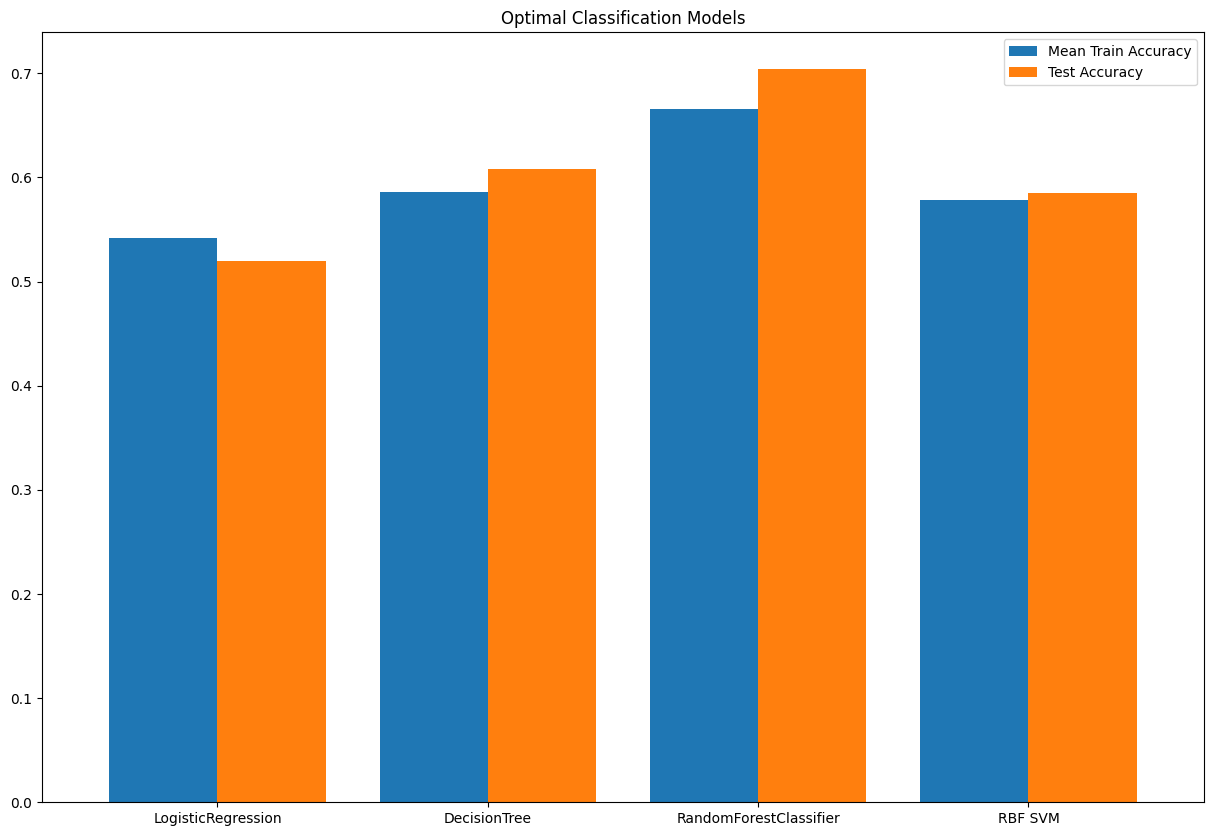

In [921]:
# Make a graph of scores
ClassiNames2 = list[optiOutput.keys()]
ClassiScores2 = [[optiOutput['LRC']['Mean Train Accuracy'], optiOutput['LRC']['Test Accuracy']],
                [optiOutput['DT']['Mean Train Accuracy'], optiOutput['DT']['Test Accuracy']],
                [optiOutput['RFC']['Mean Train Accuracy'], optiOutput['RFC']['Test Accuracy']],
                [optiOutput['RBFSVM']['Mean Train Accuracy'], optiOutput['RBFSVM']['Test Accuracy']]]

ClassiScoresDf2 = pd.DataFrame(ClassiScores2, columns=['Mean Train Accuracy', 'Test Accuracy'])

PltClassiScoresDf2 = ClassiScoresDf2.plot(kind='bar', title = "Optimal Classification Models", figsize=(15, 10), width=0.8)
PltClassiScoresDf2.set_xticklabels(['LogisticRegression', 'DecisionTree', 'RandomForestClassifier', 'RBF SVM'], rotation = 0)